In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa as tsa
import itertools
from tqdm import tqdm_notebook

plt.style.use("fivethirtyeight")

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
plt.rcParams["figure.figsize"]=(10,8)

In [3]:
df_original = pd.read_excel('Energy.xlsx')
df_time = df_original.set_index('Time')

### Since this Data is Recorded at 5 mins interval. First, we will change it to Daily Data

In [4]:
df_day = df_time.resample('D').agg({'Solar Power (MW)':'max','Windspeed (mph)':'max'})
print('Total Solar Power Produced in 2019: {:.2f}'.format(df_day['Solar Power (MW)'].sum()))
df_day = df_day.replace({'Windspeed (mph)':{0:np.median(df_day['Windspeed (mph)'])}})

Total Solar Power Produced in 2019: 1043.36


In [5]:
df_day.describe().style.background_gradient()

,Solar Power (MW),Windspeed (mph)
count,365.000000,365.000000
mean,2.858521,13.135740
std,0.553077,12.115338
min,0.490000,0.280000
25%,2.640000,2.124000
50%,2.940000,6.228000
75%,3.240000,30.000000
max,3.840000,30.000000


* We see there is no missing value.
* Windspeed Data seems to have some outliers. Mean value and Median are quite different. Let's see the box plot

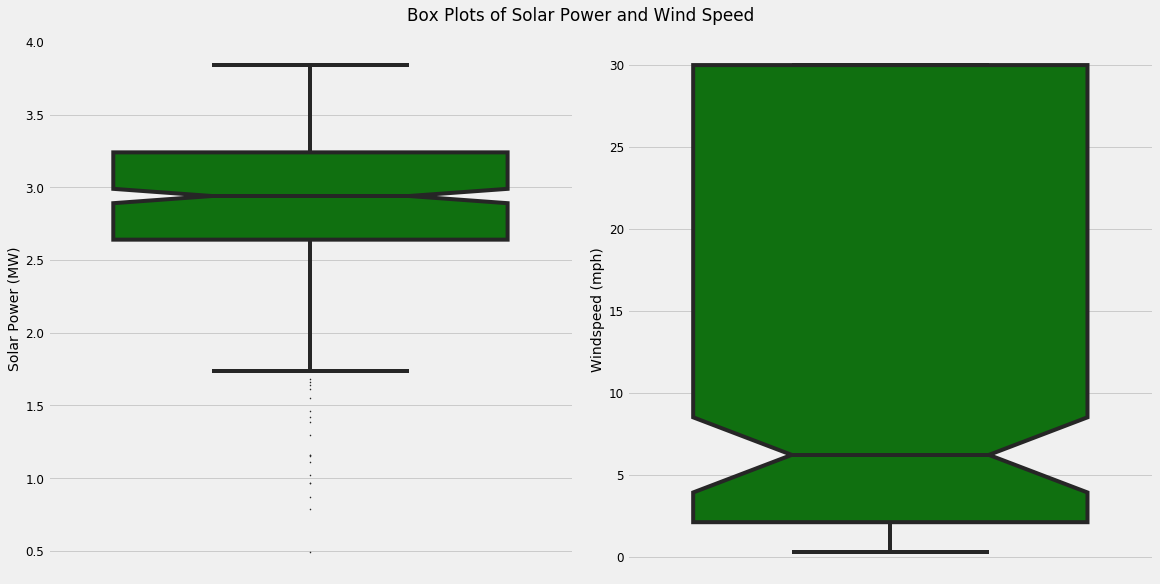

In [6]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8), constrained_layout=True)

sn.boxplot(df_day['Solar Power (MW)'], orient="v", color='g',notch=True, width=0.75, fliersize=0.7 ,ax=ax1);

sn.boxplot(df_day['Windspeed (mph)'], orient="v", color='g',notch=True, width=0.75, fliersize=0.7 ,ax=ax2);

f.suptitle('Box Plots of Solar Power and Wind Speed');

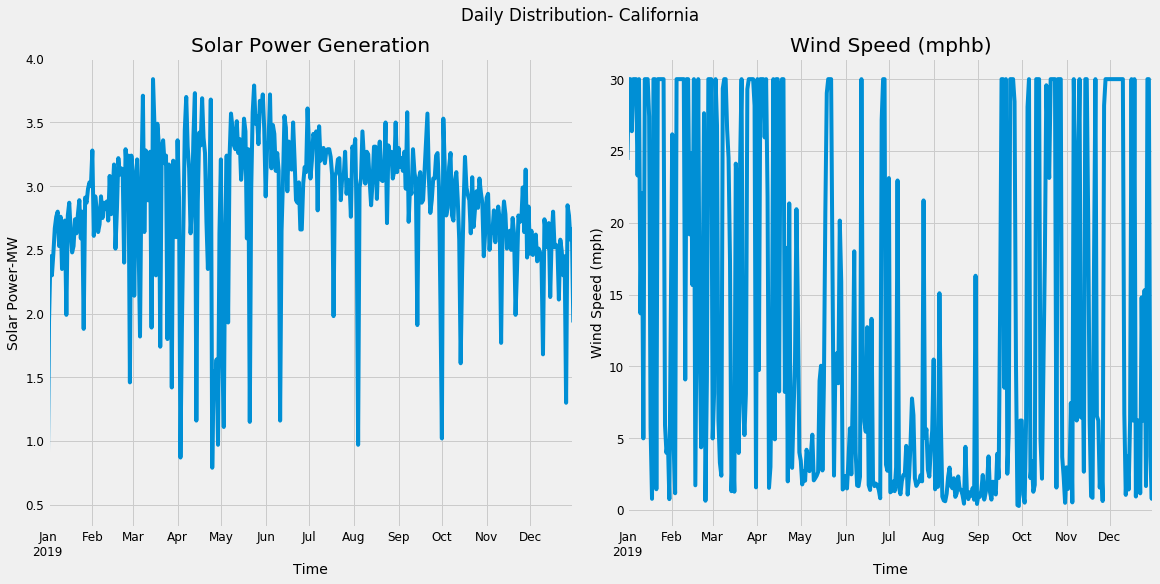

In [7]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8), constrained_layout=True)

df_day['Solar Power (MW)'].plot(ax=ax1);
ax1.set_ylabel('Solar Power-MW');
ax1.set_title('Solar Power Generation');

df_day['Windspeed (mph)'].plot(ax=ax2);
ax2.set_ylabel('Wind Speed (mph)');
ax2.set_title('Wind Speed (mphb)');
f.suptitle('Daily Distribution- California');

* We see there is huge variations in the data & also there seems to be a trend in both the time series.
* Let's make a different dataframes for both the time series
* As there seems to be a trend, differencing may remove the trend. Then let's split the data set into test-train

In [8]:
df_solar = df_day['Solar Power (MW)'].copy()
df_wind = df_day['Windspeed (mph)'].copy()

df_solar_diff = np.log(df_solar).diff(periods=1)
df_solar_diff.dropna(inplace=True)
df_wind_diff = np.log(df_wind).diff(periods=1)
df_wind_diff.dropna(inplace=True)

df_solar_train = df_solar_diff.iloc[:275].copy()
df_solar_test = df_solar_diff.iloc[275:].copy()

df_wind_train = df_wind_diff.iloc[:275].copy()
df_wind_test = df_wind_diff.iloc[275:].copy()

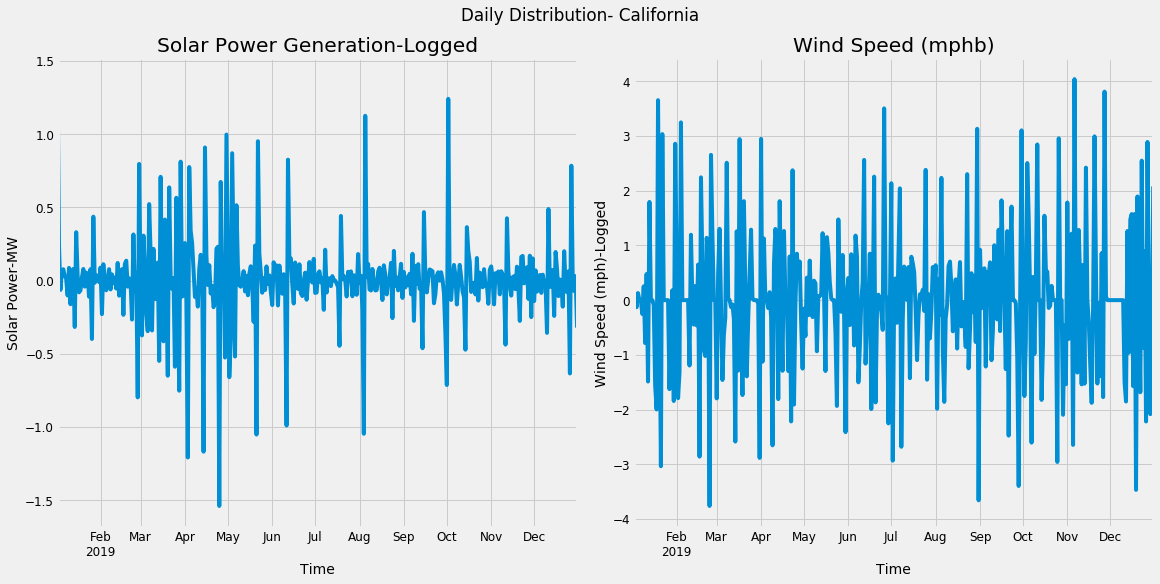

In [9]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8), constrained_layout=True)

df_solar_diff.plot(ax=ax1);
ax1.set_ylabel('Solar Power-MW');
ax1.set_title('Solar Power Generation-Logged');

df_wind_diff.plot(ax=ax2);
ax2.set_ylabel('Wind Speed (mph)-Logged');
ax2.set_title('Wind Speed (mphb)');
f.suptitle('Daily Distribution- California');

* Differencing the series at lag 1, removes the trend. The variations are still there.

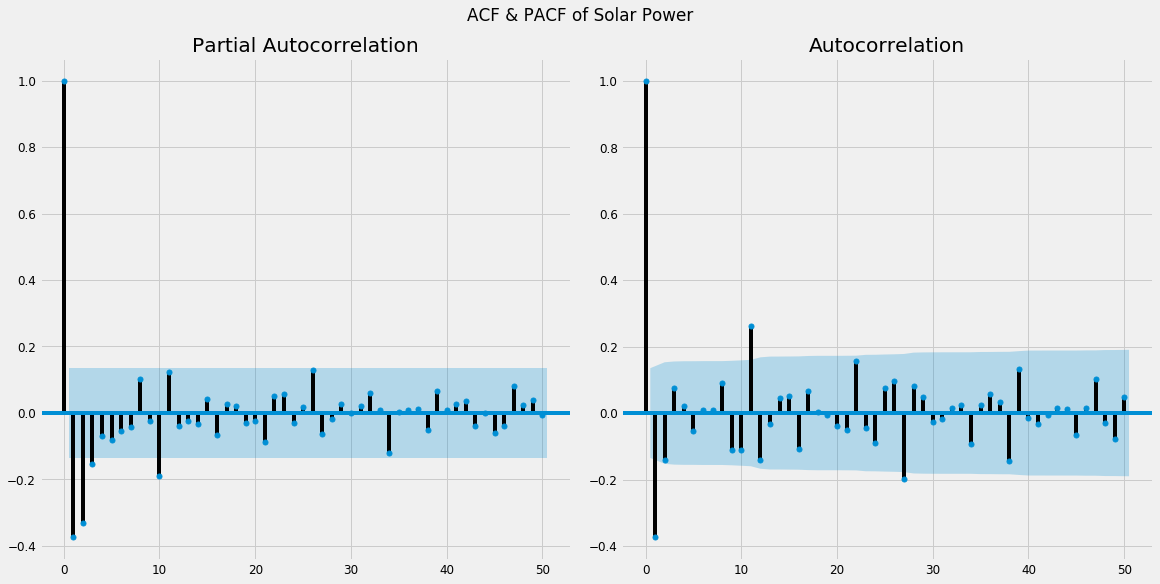

In [10]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8), constrained_layout=True)

smt.graphics.plot_pacf(df_solar_diff, alpha=0.01, ax=ax1, lags=50);
smt.graphics.plot_acf(df_solar_diff, alpha=0.01, ax=ax2, lags=50);
f.suptitle('ACF & PACF of Solar Power');
plt.savefig('Solar ACF.png');

* From ACF & PACF we see there is no significant correlation
* Further we can verify this from ADF and Ljung Box Test

# Testing whether the series is stationary or not

* __AD Fueller Test__

In [11]:
#Applying the Dicker Fuller Test
result_windspeed = tsa.stattools.adfuller(df_day['Windspeed (mph)'], maxlag=100, autolag='AIC')
result_solarpower = tsa.stattools.adfuller(df_day['Solar Power (MW)'], maxlag=100, autolag='AIC')

print('\n-------------------------\nWind Speed Results\n-------------------------\n',
     '\tADA Statistics: {}\n'.format(result_windspeed[0]),
     '\tp-Value: {}\n'.format(result_windspeed[1]),
      '\tNr of Lags Considered: {}\n'.format(result_windspeed[2]),
     '\tCritical Values: ')
for key, value in result_windspeed[4].items():
    print('\t{}: {}'.format(key, value))
    
    
print('\n-------------------------\nSolar Power Results\n-------------------------\n',
     '\tADA Statistics: {}\n'.format(result_solarpower[0]),
     '\tp-Value: {}\n'.format(result_solarpower[1]),
      '\tNr of Lags Considered: {}\n'.format(result_solarpower[2]),
     '\tCritical Values: ')
for key, value in result_solarpower[4].items():
    print('\t{}: {}'.format(key, value))


-------------------------
Wind Speed Results
-------------------------
 	ADA Statistics: -4.9483107913919
 	p-Value: 2.8059863822768114e-05
 	Nr of Lags Considered: 5
 	Critical Values: 
	1%: -3.4486972813047574
	5%: -2.8696246923288418
	10%: -2.571077032068342

-------------------------
Solar Power Results
-------------------------
 	ADA Statistics: -3.742942426536948
 	p-Value: 0.0035481120615246074
 	Nr of Lags Considered: 11
 	Critical Values: 
	1%: -3.4490114443793214
	5%: -2.8697627072503757
	10%: -2.5711506161673716


* __From the ADF test, for the both the series the p-value is less than the critical value & also ADA statistics is also low than 1%. So we can say the series are stationary__

In [12]:
sm.stats.acorr_ljungbox(df_day['Windspeed (mph)'], lags=[10])
sm.stats.acorr_ljungbox(df_day['Solar Power (MW)'], lags=[10])

(array([117.54204299]), array([1.59428682e-20]))

In [13]:
print(sm.stats.acorr_ljungbox(df_wind_diff, lags=[10]))
sm.stats.acorr_ljungbox(df_solar_diff, lags=[10])

(array([55.22570216]), array([2.86581839e-08]))


(array([74.62422101]), array([5.63020677e-12]))

* __Decomposing Time Series to check seasonality & trends__

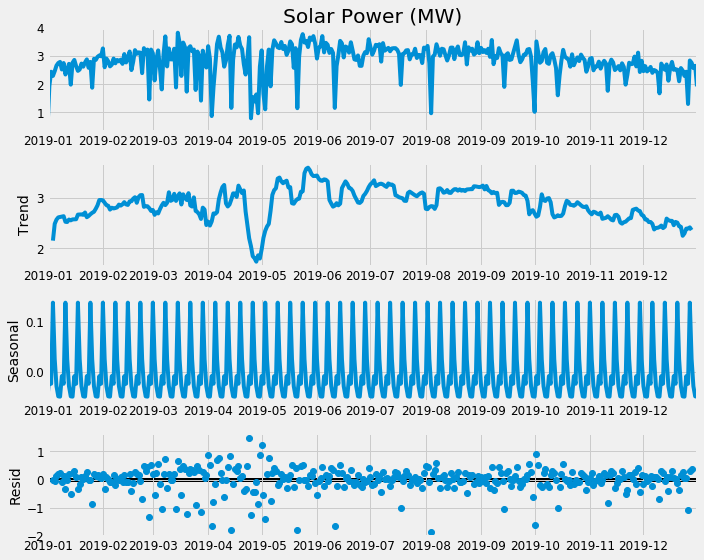

In [14]:
decomposition = sm.tsa.seasonal_decompose(df_day['Solar Power (MW)'],model="additive")
decomposition.plot();

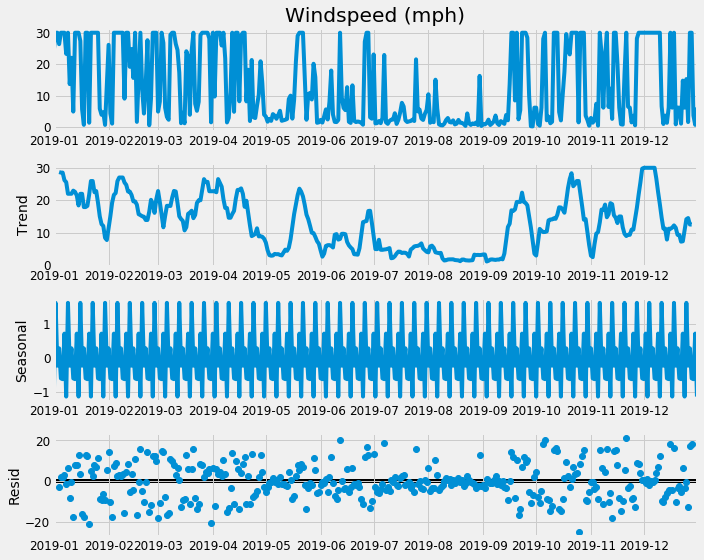

In [15]:
decomposition = sm.tsa.seasonal_decompose(df_day['Windspeed (mph)'],model="additive")
decomposition.plot();

* __Difference Time Seires Decompositions__

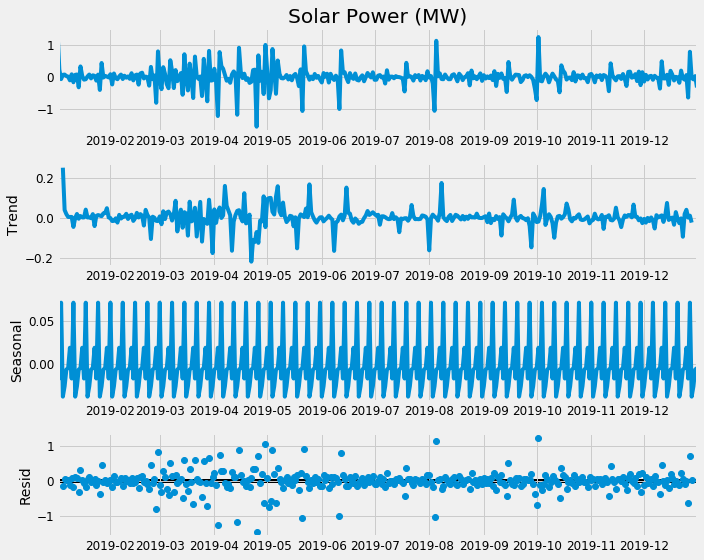

In [16]:
decomposition = sm.tsa.seasonal_decompose(df_solar_diff,model="additive")
decomposition.plot();

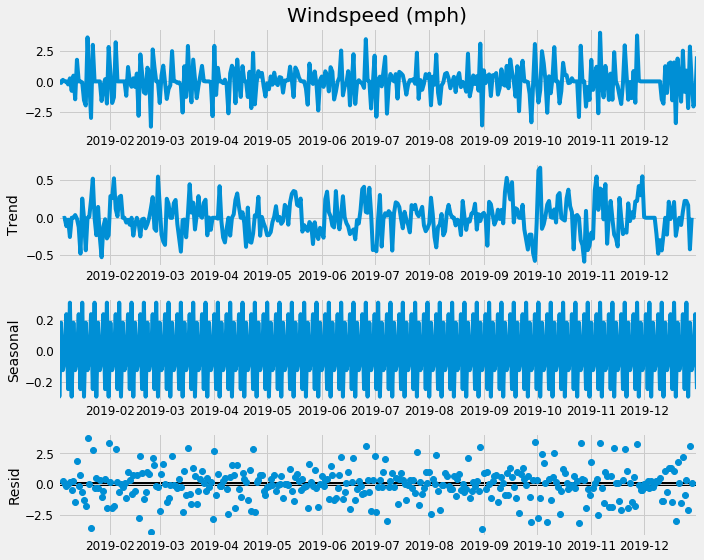

In [17]:
decomposition = sm.tsa.seasonal_decompose(df_wind_diff,model="additive")
decomposition.plot();

# Fitting ARIMA Model

In [18]:
# Train many SARIMA models to find the best set of parameters
def SARIMA_best_model(parameters_list,s,data):
    """z
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data, order=(param[0], param[1], param[2]),
                                               seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        rmse_train = model.mse
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        
        results.append([param, model.aic, rmse_train])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['Parameters', 'AIC', 'MSE_Train']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_table, best_model

In [19]:
#Set initial values and some bounds
ps = range(0, 8);
d = range(0, 2);
qs = range(0, 3);
Ps = range(0, 2);
D = range(0,2);
Qs = range(0, 1);
s = 11;
#Create a list with all possible combinations of parameters
parameters = itertools.product(ps, qs, d, Ps, D, Qs);
parameters_list = list(parameters);

In [20]:
data = np.log(df_day['Solar Power (MW)'])
results_solar, solar_best_model = SARIMA_best_model(parameters_list,s,data)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

In [21]:
forcast113 = solar_best_model.get_forecast(30)

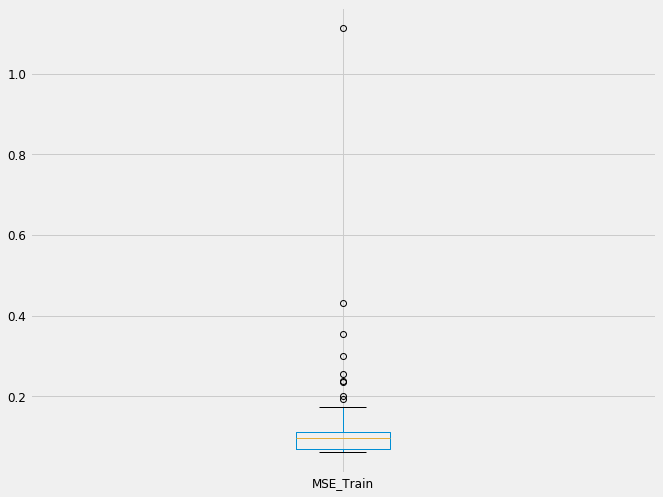

In [22]:
results_solar['MSE_Train'].plot(kind='box')

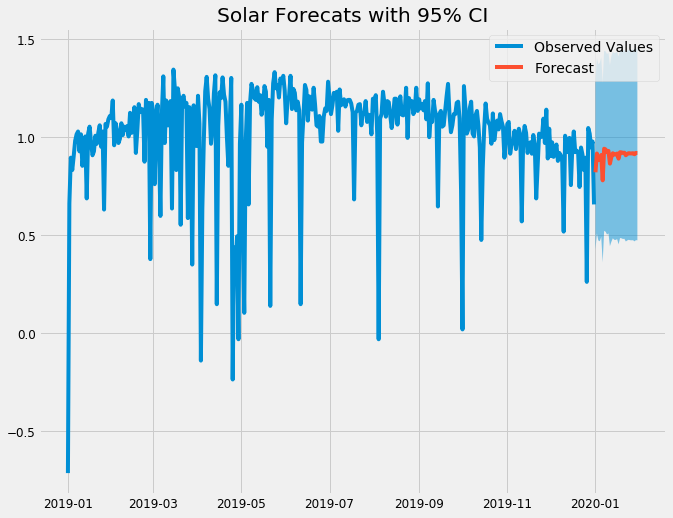

In [23]:
plt.plot(data.index, data, label='Observed Values')
plt.plot(forcast113.predicted_mean.index, forcast113.predicted_mean, label='Forecast')
plt.fill_between(forcast113.predicted_mean.index, forcast113.conf_int(alpha=0.10).iloc[:, 0], 
                 forcast113.conf_int().iloc[:, 1], alpha=0.5)
plt.legend(loc='best')
plt.title('Solar Forecats with 95% CI');

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

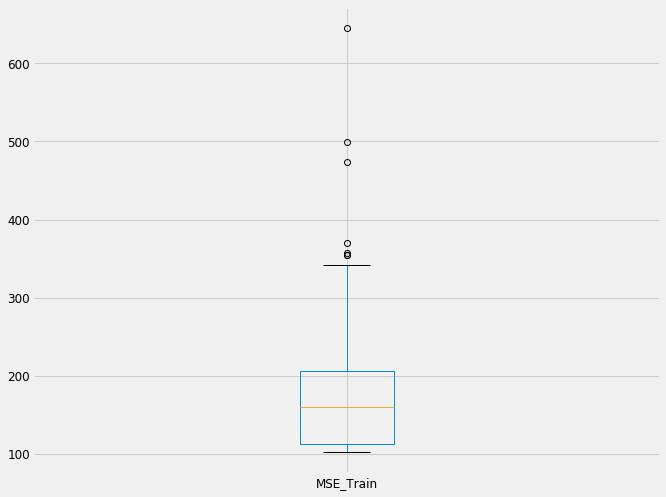

In [24]:
data = df_day['Windspeed (mph)']
results_solar, solar_best_model = SARIMA_best_model(parameters_list,s,data)
forcast113 = solar_best_model.get_forecast(30)
results_solar['MSE_Train'].plot(kind='box')

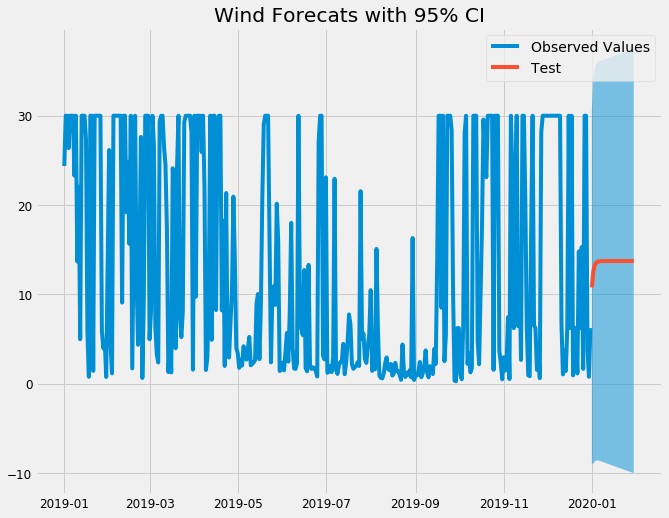

In [25]:
plt.plot(data.index, data, label='Observed Values')
plt.plot(forcast113.predicted_mean.index, forcast113.predicted_mean, label='Test')
plt.fill_between(forcast113.predicted_mean.index, forcast113.conf_int(alpha=0.05).iloc[:, 0], 
                 forcast113.conf_int().iloc[:, 1], alpha=0.5)
plt.legend(loc='best')
plt.title('Wind Forecats with 95% CI');